# Prep

In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
data_dir = '/kaggle/input/ethz-cil-monocular-depth-estimation-2025'
train_dir = os.path.join(data_dir, 'train/train')
test_dir = os.path.join(data_dir, 'test/test')
train_list_file = os.path.join(data_dir, 'train_list.txt')
test_list_file = os.path.join(data_dir, 'test_list.txt')
output_dir = '/kaggle/working/'
results_dir = os.path.join(output_dir, 'results')
predictions_dir = os.path.join(output_dir, 'predictions')

### Hyperparameters

In [21]:
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 1
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_SIZE = (426, 560)
NUM_WORKERS = 4
PIN_MEMORY = True

### Helper functions

In [22]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def target_transform(depth):
    # Resize the depth map to match input size
    depth = torch.nn.functional.interpolate(
        depth.unsqueeze(0).unsqueeze(0), 
        size=INPUT_SIZE, 
        mode='bilinear', 
        align_corners=True
    ).squeeze()
    
    # Add channel dimension to match model output
    depth = depth.unsqueeze(0)
    return depth

# Dataset

In [24]:
class DepthDataset(Dataset):
    def __init__(self, data_dir, list_file, transform=None, target_transform=None, has_gt=True):
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.has_gt = has_gt
        
        # Read file list
        with open(list_file, 'r') as f:
            if has_gt:
                self.file_pairs = [line.strip().split() for line in f]
            else:
                # For test set without ground truth
                self.file_list = [line.strip() for line in f]
    
    def __len__(self):
        return len(self.file_pairs if self.has_gt else self.file_list)
    
    def __getitem__(self, idx):
        if self.has_gt:
            rgb_path = os.path.join(self.data_dir, self.file_pairs[idx][0])
            depth_path = os.path.join(self.data_dir, self.file_pairs[idx][1])
            
            # Load RGB image
            rgb = Image.open(rgb_path).convert('RGB')
            
            # Load depth map
            depth = np.load(depth_path).astype(np.float32)
            depth = torch.from_numpy(depth)
            
            # Apply transformations
            if self.transform:
                rgb = self.transform(rgb)
            
            if self.target_transform:
                depth = self.target_transform(depth)
            else:
                # Add channel dimension if not done by transform
                depth = depth.unsqueeze(0)
            
            return rgb, depth, self.file_pairs[idx][0]  # Return filename for saving predictions
        else:
            # For test set without ground truth
            rgb_path = os.path.join(self.data_dir, self.file_list[idx].split(' ')[0])
            
            # Load RGB image
            rgb = Image.open(rgb_path).convert('RGB')
            
            # Apply transformations
            if self.transform:
                rgb = self.transform(rgb)
            
            return rgb, self.file_list[idx]  # No depth, just return the filename

# Model - U-net

In [25]:
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

In [26]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        
        # Encoder blocks
        self.enc1 = UNetBlock(3, 64)
        self.enc2 = UNetBlock(64, 128)
        
        # Decoder blocks
        self.dec2 = UNetBlock(128 + 64, 64)
        self.dec1 = UNetBlock(64, 32)
        
        # Final layer
        self.final = nn.Conv2d(32, 1, kernel_size=1)
        
        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        x = self.pool(enc1)
        
        x = self.enc2(x)
        
        # Decoder with skip connections
        x = nn.functional.interpolate(x, size=enc1.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, enc1], dim=1)
        x = self.dec2(x)
        
        x = self.dec1(x)
        x = self.final(x)
        
        # Output non-negative depth values
        x = torch.sigmoid(x)*10
        
        return x

# Training loop

In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the model and save the best based on validation metrics"""
    best_val_loss = float('inf')
    best_epoch = 0
    train_losses = []
    val_losses = []
        
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets, _ in tqdm(train_loader, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets, _ in tqdm(val_loader, desc="Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
                
        print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), os.path.join(results_dir, 'best_model.pth'))
            print(f"New best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")
    
    print(f"\nBest model was from epoch {best_epoch+1} with validation loss: {best_val_loss:.4f}")
    
    # Load the best model
    model.load_state_dict(torch.load(os.path.join(results_dir, 'best_model.pth')))
    
    return model

# Model evaluation

In [29]:
def evaluate_model(model, val_loader, device):
    """Evaluate the model and compute metrics on validation set"""
    model.eval()
    
    mae = 0.0
    rmse = 0.0
    rel = 0.0
    delta1 = 0.0
    delta2 = 0.0
    delta3 = 0.0
    sirmse = 0.0
    
    total_samples = 0
    target_shape = None
    
    with torch.no_grad():
        for inputs, targets, filenames in tqdm(val_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            batch_size = inputs.size(0)
            total_samples += batch_size
            
            if target_shape is None:
                target_shape = targets.shape
            

            # Forward pass
            outputs = model(inputs)
            
            # Resize outputs to match target dimensions
            outputs = nn.functional.interpolate(
                outputs,
                size=targets.shape[-2:],  # Match height and width of targets
                mode='bilinear',
                align_corners=True
            )
            
            # Calculate metrics
            abs_diff = torch.abs(outputs - targets)
            mae += torch.sum(abs_diff).item()
            rmse += torch.sum(torch.pow(abs_diff, 2)).item()
            rel += torch.sum(abs_diff / (targets + 1e-6)).item()
            
            # Calculate scale-invariant RMSE for each image in the batch
            for i in range(batch_size):
                # Convert tensors to numpy arrays
                pred_np = outputs[i].cpu().squeeze().numpy()
                target_np = targets[i].cpu().squeeze().numpy()
                
                EPSILON = 1e-6
                
                valid_target = target_np > EPSILON
                if not np.any(valid_target):
                    continue
                
                target_valid = target_np[valid_target]
                pred_valid = pred_np[valid_target]
                
                log_target = np.log(target_valid)
                
                pred_valid = np.where(pred_valid > EPSILON, pred_valid, EPSILON)
                log_pred = np.log(pred_valid)
                
                # Calculate scale-invariant error
                diff = log_pred - log_target
                diff_mean = np.mean(diff)
                
                # Calculate RMSE for this image
                sirmse += np.sqrt(np.mean((diff - diff_mean) ** 2))
            
            # Calculate thresholded accuracy
            max_ratio = torch.max(outputs / (targets + 1e-6), targets / (outputs + 1e-6))
            delta1 += torch.sum(max_ratio < 1.25).item()
            delta2 += torch.sum(max_ratio < 1.25**2).item()
            delta3 += torch.sum(max_ratio < 1.25**3).item()
            
            # Save some sample predictions
            if total_samples <= 5 * batch_size:
                for i in range(min(batch_size, 5)):
                    idx = total_samples - batch_size + i
                    
                    # Convert tensors to numpy arrays
                    input_np = inputs[i].cpu().permute(1, 2, 0).numpy()
                    target_np = targets[i].cpu().squeeze().numpy()
                    output_np = outputs[i].cpu().squeeze().numpy()
                    
                    # Normalize for visualization
                    input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min() + 1e-6)
                    
                    # Create visualization
                    plt.figure(figsize=(15, 5))
                    
                    plt.subplot(1, 3, 1)
                    plt.imshow(input_np)
                    plt.title("RGB Input")
                    plt.axis('off')
                    
                    plt.subplot(1, 3, 2)
                    plt.imshow(target_np, cmap='plasma')
                    plt.title("Ground Truth Depth")
                    plt.axis('off')
                    
                    plt.subplot(1, 3, 3)
                    plt.imshow(output_np, cmap='plasma')
                    plt.title("Predicted Depth")
                    plt.axis('off')
                    
                    plt.tight_layout()
                    plt.savefig(os.path.join(results_dir, f"sample_{idx}.png"))
                    plt.close()
            
            # Free up memory
            del inputs, targets, outputs, abs_diff, max_ratio
            
        # Clear CUDA cache
        torch.cuda.empty_cache()
    
    # Calculate final metrics using stored target shape
    total_pixels = target_shape[1] * target_shape[2] * target_shape[3]  # channels * height * width
    mae /= total_samples * total_pixels
    rmse = np.sqrt(rmse / (total_samples * total_pixels))
    rel /= total_samples * total_pixels
    sirmse = sirmse / total_samples
    delta1 /= total_samples * total_pixels
    delta2 /= total_samples * total_pixels
    delta3 /= total_samples * total_pixels
    
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'siRMSE': sirmse,
        'REL': rel,
        'Delta1': delta1,
        'Delta2': delta2,
        'Delta3': delta3
    }
    
    return metrics

# Generate test predictions

In [30]:
def generate_test_predictions(model, test_loader, device):
    """Generate predictions for the test set without ground truth"""
    model.eval()
    
    # Ensure predictions directory exists
    ensure_dir(predictions_dir)
    
    with torch.no_grad():
        for inputs, filenames in tqdm(test_loader, desc="Generating Test Predictions"):
            inputs = inputs.to(device)
            batch_size = inputs.size(0)
            
            # Forward pass
            outputs = model(inputs)
            
            # Resize outputs to match original input dimensions (426x560)
            outputs = nn.functional.interpolate(
                outputs,
                size=(426, 560),  # Original input dimensions
                mode='bilinear',
                align_corners=True
            )
            
            # Save all test predictions
            for i in range(batch_size):
                # Get filename without extension
                filename = filenames[i].split(' ')[1]
                
                # Save depth map prediction as numpy array
                depth_pred = outputs[i].cpu().squeeze().numpy()
                np.save(os.path.join(predictions_dir, f"{filename}"), depth_pred)
            
            # Clean up memory
            del inputs, outputs
        
        # Clear cache after test predictions
        torch.cuda.empty_cache()

# Putting it all together

In [31]:
def main():

    # Create output directories
    ensure_dir(results_dir)
    ensure_dir(predictions_dir)
    
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create training dataset with ground truth
    train_full_dataset = DepthDataset(
        data_dir=train_dir,
        list_file=train_list_file, 
        transform=train_transform,
        target_transform=target_transform,
        has_gt=True
    )
    
    # Create test dataset without ground truth
    test_dataset = DepthDataset(
        data_dir=test_dir,
        list_file=test_list_file,
        transform=test_transform,
        has_gt=False  # Test set has no ground truth
    )
    
    # Split training dataset into train and validation
    total_size = len(train_full_dataset)
    train_size = int(0.85 * total_size)  # 85% for training
    val_size = total_size - train_size    # 15% for validation
    
    # Set a fixed random seed for reproducibility
    torch.manual_seed(0)
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_full_dataset, [train_size, val_size]
    )
    
    # Create data loaders with memory optimizations
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=NUM_WORKERS, 
        pin_memory=PIN_MEMORY,
        drop_last=True,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=NUM_WORKERS, 
        pin_memory=PIN_MEMORY
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=NUM_WORKERS, 
        pin_memory=PIN_MEMORY
    )
    
    print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")
    
    # Clear CUDA cache before model initialization
    torch.cuda.empty_cache()
    
    # Display GPU memory info
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        print(f"Initially allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    
    model = SimpleUNet()
    model = nn.DataParallel(model)
    model = model.to(DEVICE)
    print(f"Using device: {DEVICE}")

    # Print memory usage after model initialization
    if torch.cuda.is_available():
        print(f"Memory allocated after model init: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    
    # Train the model
    print("Starting training...")
    model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, DEVICE)
            
    # Evaluate the model on validation set
    print("Evaluating model on validation set...")
    metrics = evaluate_model(model, val_loader, DEVICE)
    
    # Print metrics
    print("\nValidation Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    # Save metrics to file
    with open(os.path.join(results_dir, 'validation_metrics.txt'), 'w') as f:
        for name, value in metrics.items():
            f.write(f"{name}: {value:.4f}\n")
    
    # Generate predictions for the test set
    print("Generating predictions for test set...")
    generate_test_predictions(model, test_loader, DEVICE)
    
    print(f"Results saved to {results_dir}")
    print(f"All test depth map predictions saved to {predictions_dir}")

In [32]:
main()

Train size: 20375, Validation size: 3596, Test size: 650
GPU: Tesla T4
Total GPU memory: 15.83 GB
Initially allocated: 0.00 GB
Using device: cuda
Memory allocated after model init: 0.00 GB
Starting training...
Epoch 1/1


Validation: 100%|██████████| 899/899 [01:19<00:00, 11.25it/s]
<ipython-input-28-d871bdcce43a>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

Train Loss: 2.1871, Validation Loss: 2.0360
New best model saved at epoch 1 with validation loss: 2.0360

Best model was from epoch 1 with validation loss: 2.0360
Evaluating model on validation set...


Evaluating: 100%|██████████| 899/899 [01:43<00:00,  8.72it/s]



Validation Metrics:
MAE: 1.0874
RMSE: 1.4256
siRMSE: 0.3300
REL: 0.4902
Delta1: 0.3816
Delta2: 0.6558
Delta3: 0.8260
Generating predictions for test set...


Generating Test Predictions: 100%|██████████| 163/163 [00:14<00:00, 11.15it/s]


Results saved to /kaggle/working/results
All test depth map predictions saved to /kaggle/working/predictions


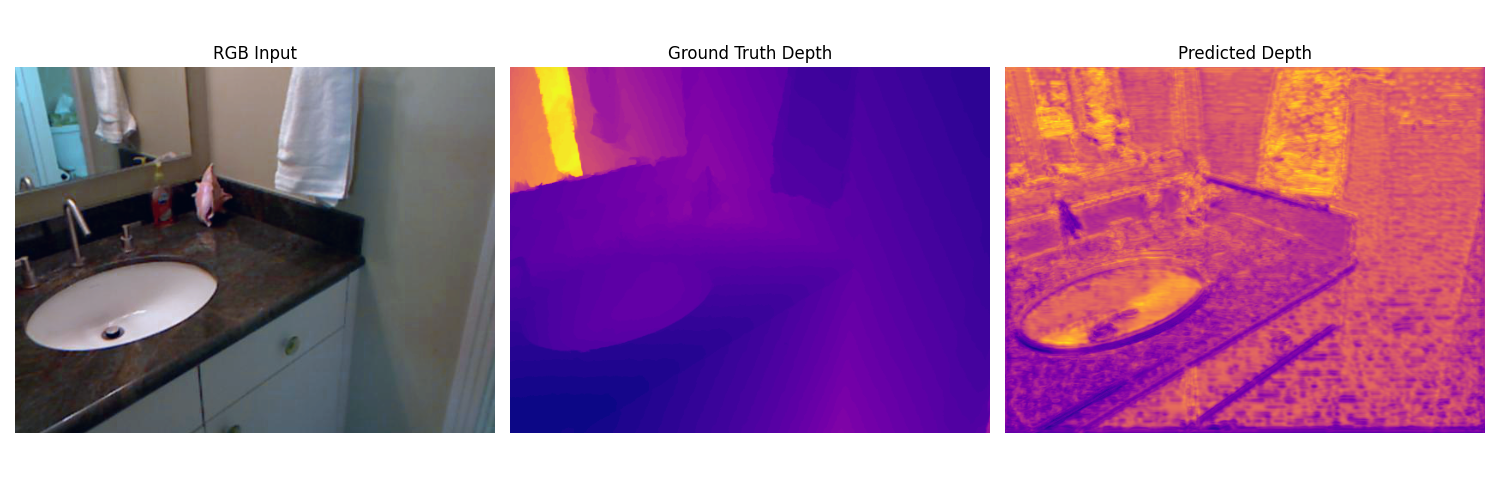

In [33]:
# Open a sample prediction from validation set
Image.open('/kaggle/working/results/sample_0.png')